# Monte-Carlo AMSE Study – Donoho–Johnstone **BUMPS** Signal

This notebook evaluates wavelet denoising performance on the Donoho–Johnstone **Bumps** test function:
$$
f(t) = \sum_{i=1}^{11} h_i\left(1+\left|\frac{t - t_i}{w_i}\right|\right)^{-4}, \qquad t \in [0,1],
$$
sampled at $N = 1024$ equally spaced points.

Gaussian noise $\varepsilon \sim N(0,\sigma^2)$ is added such that the **signal-to-noise variance ratio** satisfies
$$
\mathrm{SNR} = \frac{\mathrm{Var}(\text{signal})}{\mathrm{Var}(\text{noise})} = 7,
$$
and
$$
\lambda_U = \sigma\sqrt{2\log N}
$$
is the **universal wavelet threshold**.

Shrinkage rules compared:
- Hard thresholding (universal rule)
- Soft thresholding (universal rule)
- SCAD shrinkage (Fan–Li), using oracle–selected $\lambda^\*$
- Smooth–SCAD (raised–cosine transition), oracle–selected $\lambda^\*$

Two experiments are run:

1. **Single Run (M = 1)**  
   One noisy realization is generated and reconstructions are plotted:
   $$\hat f_{\mathrm{hard}},\; \hat f_{\mathrm{soft}},\; \hat f_{\mathrm{SCAD}},\; \hat f_{\mathrm{SmoothSCAD}}.$$

2. **Monte-Carlo AMSE (M = 500)**  
   For each noise replication, denoising is applied and MSE is computed:
   $$
   \mathrm{AMSE} = \frac{1}{M}\sum_{m=1}^M \frac{1}{N}\sum_{i=1}^N \left(\hat f^{(m)}(i) - f(i)\right)^2.
   $$

The notebook prints:
- AMSE values for all shrinkage rules
- Optional standard deviations of MSE across repetitions
- A dictionary of AMSE results for downstream tables or plots


Single-run MSEs (Bumps, N=1024, wavelet=db3, SNR(variance)=7.0):
  Hard (univ):         2.4907e-02 (lambda = 0.940)
  Soft (univ):         7.4950e-02 (lambda = 0.940)
  SCAD (best oracle):  1.7380e-02 (lambda = 0.390, a = 3.70)
  Smooth SCAD (best):  1.7148e-02 (lambda = 0.455, a = 3.00)


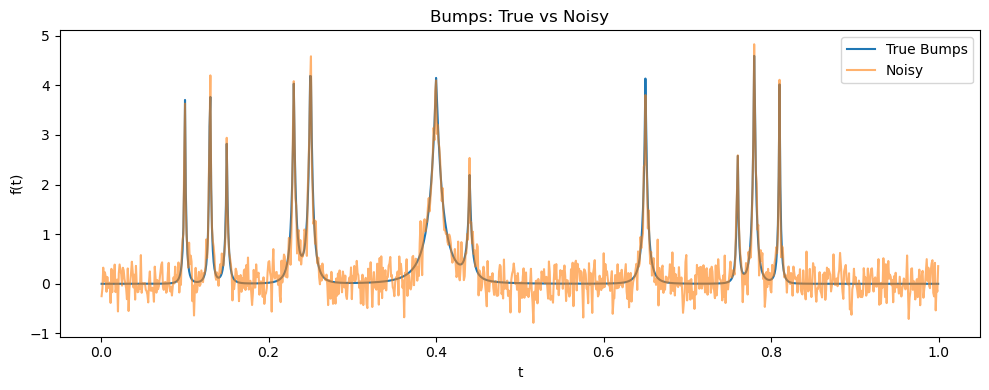

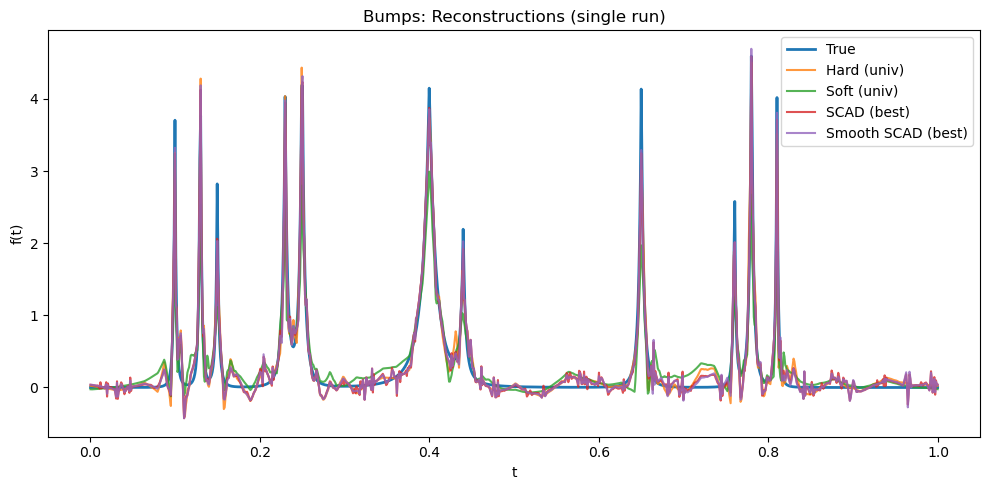

Completed 50 / 500 runs
Completed 100 / 500 runs
Completed 150 / 500 runs
Completed 200 / 500 runs
Completed 250 / 500 runs
Completed 300 / 500 runs
Completed 350 / 500 runs
Completed 400 / 500 runs
Completed 450 / 500 runs
Completed 500 / 500 runs

AMSE over M = 500 runs (Bumps, N=1024, wavelet=db3, SNR(variance)=7.0):
  Hard (univ):        2.5278e-02
  Soft (univ):        7.1512e-02
  SCAD (best oracle): 1.7429e-02 (a = 3.70)
  Smooth SCAD (best): 1.7249e-02 (a = 3.00)

AMSE results dict: {'amse_hard': np.float64(0.02527798915041228), 'amse_soft': np.float64(0.0715115758006847), 'amse_scad': np.float64(0.017428607446044856), 'amse_smooth': np.float64(0.017248946379077416)}


In [2]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# ============================================================
# 1. Donoho–Johnstone Bumps test signal
# ============================================================

def make_bumps(N=1024):
    """
    Donoho–Johnstone 'Bumps' test function on [0,1] sampled at N points.
    """
    t = (np.arange(N) + 0.5) / N
    # Standard parameters (locations, heights, widths)
    t_i = np.array([0.10, 0.13, 0.15, 0.23, 0.25,
                    0.40, 0.44, 0.65, 0.76, 0.78, 0.81])
    h_i = np.array([4.0, 5.0, 3.0, 4.0, 5.0,
                    4.2, 2.1, 4.3, 3.1, 5.1, 4.2])
    w_i = np.array([0.005, 0.005, 0.006, 0.010, 0.010,
                    0.030, 0.010, 0.010, 0.005, 0.008, 0.005])

    f = np.zeros_like(t)
    for ti, hi, wi in zip(t_i, h_i, w_i):
        f += hi * (1 + np.abs((t - ti) / wi)) ** (-4)
    return f


# ============================================================
# 2. Noise & SNR helpers
# ============================================================

def add_noise_snr_variance(x, snr_var=7.0, rng=None):
    """
    Add N(0, sigma^2) noise so that Var(x) / Var(noise) = snr_var.
    """
    if rng is None:
        rng = np.random.default_rng()
    sig_var = np.var(x)
    noise_var = sig_var / snr_var
    sigma = np.sqrt(noise_var)
    noise = rng.normal(0.0, sigma, size=len(x))
    return x + noise, sigma


def mse(x_true, x_hat):
    return np.mean((x_true - x_hat) ** 2)


def universal_threshold(sigma, N):
    return sigma * np.sqrt(2.0 * np.log(N))


# ============================================================
# 3. Wavelet denoising helpers
# ============================================================

def dwt_decompose(x, wavelet, level=None):
    return pywt.wavedec(x, wavelet, mode='periodization', level=level)


def dwt_reconstruct(coeffs, wavelet, N):
    x_rec = pywt.waverec(coeffs, wavelet, mode='periodization')
    return x_rec[:N]


def universal_hard_soft_denoise(y, sigma, wavelet_name='db3',
                                mode='hard', level=None):
    """
    Universal threshold hard/soft denoising.
    """
    N = len(y)
    wavelet = pywt.Wavelet(wavelet_name)
    if level is None:
        level = pywt.dwt_max_level(N, wavelet.dec_len)

    lam = universal_threshold(sigma, N)
    coeffs = dwt_decompose(y, wavelet, level=level)
    cA = coeffs[0]
    details = coeffs[1:]
    thr_details = [pywt.threshold(cd, lam, mode=mode) for cd in details]
    coeffs_thr = [cA] + thr_details
    x_rec = dwt_reconstruct(coeffs_thr, wavelet, N)
    return x_rec, lam


# ============================================================
# 4. SCAD and smooth SCAD shrinkers (coefficientwise)
# ============================================================

def scad_shrink(coeffs, lam, a=3.7):
    """
    SCAD thresholding (Fan & Li 2001) applied elementwise.
    """
    x = np.asarray(coeffs)
    absx = np.abs(x)
    sgn = np.sign(x)
    res = np.zeros_like(x)

    # Region |x| <= lambda -> 0 (already res=0)
    # Region lambda < |x| <= 2*lambda
    mask1 = (absx > lam) & (absx <= 2.0 * lam)
    res[mask1] = sgn[mask1] * (absx[mask1] - lam)

    # Region 2*lambda < |x| <= a*lambda
    mask2 = (absx > 2.0 * lam) & (absx <= a * lam)
    res[mask2] = sgn[mask2] * ((a - 1.0) * absx[mask2] - a * lam) / (a - 2.0)

    # Region |x| > a*lambda -> identity
    mask3 = absx > a * lam
    res[mask3] = x[mask3]

    return res


def smooth_scad_shrink(coeffs, lam, a=3.0):
    """
    Smooth SCAD threshold with raised-cosine transition, as in the paper.
    """
    x = np.asarray(coeffs)
    absx = np.abs(x)
    sgn = np.sign(x)
    res = np.zeros_like(x)

    # Case |d| <= lambda -> 0 (already zero)
    # Case |d| >= a*lambda -> identity
    mask_tail = absx >= a * lam
    res[mask_tail] = x[mask_tail]

    # Transition region lambda < |d| < a*lambda
    mask_mid = (absx > lam) & (absx < a * lam)
    if np.any(mask_mid):
        d_mid = absx[mask_mid]
        s = (d_mid - lam) / ((a - 1.0) * lam)  # in (0,1)
        h = lam * np.cos(0.5 * np.pi * s) ** 2
        rho_mag = d_mid - h
        res[mask_mid] = sgn[mask_mid] * rho_mag

    return res


def apply_shrinker_to_coeffs(coeffs, lam, shrinker, **shrink_kwargs):
    """
    Apply a coefficientwise shrinker (e.g. SCAD, smooth SCAD)
    to all detail coefficients, keep approximation unchanged.
    """
    cA = coeffs[0]
    details = coeffs[1:]
    new_details = [shrinker(cd, lam, **shrink_kwargs) for cd in details]
    return [cA] + new_details


def best_lambda_oracle(x_true, y, wavelet_name, shrinker,
                       lam_grid, level=None, **shrink_kwargs):
    """
    For a fixed noisy realization y, choose lambda minimizing MSE
    (oracle) for a given shrinker.
    """
    N = len(y)
    wavelet = pywt.Wavelet(wavelet_name)
    if level is None:
        level = pywt.dwt_max_level(N, wavelet.dec_len)

    coeffs_noisy = dwt_decompose(y, wavelet, level=level)

    best_mse = np.inf
    best_lam = None
    best_rec = None

    for lam in lam_grid:
        coeffs_thr = apply_shrinker_to_coeffs(coeffs_noisy, lam, shrinker,
                                              **shrink_kwargs)
        x_rec = dwt_reconstruct(coeffs_thr, wavelet, N)
        cur_mse = mse(x_true, x_rec)
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_lam = lam
            best_rec = x_rec

    return best_rec, best_lam, best_mse


# ============================================================
# 5. Single-run experiment (M = 1) with plots
# ============================================================

def bumps_single_run_demo(N=1024, snr_var=7.0,
                          wavelet_name='db3', a_scad=3.7, a_smooth=3.0,
                          seed=123):
    rng = np.random.default_rng(seed)

    # True signal
    x_true = make_bumps(N)

    # Add noise with SNR in variances = snr_var
    y, sigma = add_noise_snr_variance(x_true, snr_var=snr_var, rng=rng)
    lam_U = universal_threshold(sigma, N)

    # Universal hard and soft
    x_hard, lam_hard = universal_hard_soft_denoise(
        y, sigma, wavelet_name=wavelet_name, mode='hard'
    )
    x_soft, lam_soft = universal_hard_soft_denoise(
        y, sigma, wavelet_name=wavelet_name, mode='soft'
    )

    # Grid for "best" SCAD and smooth SCAD (oracle MSE)
    lam_grid = np.linspace(0.3 * lam_U, 1.2 * lam_U, 40)

    x_scad, lam_scad, mse_scad = best_lambda_oracle(
        x_true, y, wavelet_name, scad_shrink,
        lam_grid, a=a_scad
    )
    x_smooth, lam_smooth, mse_smooth = best_lambda_oracle(
        x_true, y, wavelet_name, smooth_scad_shrink,
        lam_grid, a=a_smooth
    )

    # MSEs
    mse_hard = mse(x_true, x_hard)
    mse_soft = mse(x_true, x_soft)

    print("Single-run MSEs (Bumps, N={}, wavelet={}, SNR(variance)={}):"
          .format(N, wavelet_name, snr_var))
    print("  Hard (univ):         {:.4e} (lambda = {:.3f})".format(mse_hard, lam_hard))
    print("  Soft (univ):         {:.4e} (lambda = {:.3f})".format(mse_soft, lam_soft))
    print("  SCAD (best oracle):  {:.4e} (lambda = {:.3f}, a = {:.2f})"
          .format(mse_scad, lam_scad, a_scad))
    print("  Smooth SCAD (best):  {:.4e} (lambda = {:.3f}, a = {:.2f})"
          .format(mse_smooth, lam_smooth, a_smooth))

    # Plots
    t = (np.arange(N) + 0.5) / N

    plt.figure(figsize=(10, 4))
    plt.plot(t, x_true, label='True Bumps')
    plt.plot(t, y, label='Noisy', alpha=0.6)
    plt.title('Bumps: True vs Noisy')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.legend()
    plt.tight_layout()

    plt.figure(figsize=(10, 5))
    plt.plot(t, x_true, label='True', linewidth=2)
    plt.plot(t, x_hard, label='Hard (univ)', alpha=0.8)
    plt.plot(t, x_soft, label='Soft (univ)', alpha=0.8)
    plt.plot(t, x_scad, label='SCAD (best)', alpha=0.8)
    plt.plot(t, x_smooth, label='Smooth SCAD (best)', alpha=0.8)
    plt.title('Bumps: Reconstructions (single run)')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.legend()
    plt.tight_layout()

    plt.show()


# ============================================================
# 6. Monte Carlo AMSE (M = 500)
# ============================================================

def bumps_monte_carlo_amse(M=500, N=1024, snr_var=7.0,
                            wavelet_name='db3', a_scad=3.7, a_smooth=3.0,
                            seed=1234):
    rng = np.random.default_rng(seed)
    x_true = make_bumps(N)
    sig_var = np.var(x_true)
    noise_var = sig_var / snr_var
    sigma = np.sqrt(noise_var)
    lam_U = universal_threshold(sigma, N)

    wavelet = pywt.Wavelet(wavelet_name)
    level = pywt.dwt_max_level(N, wavelet.dec_len)

    # Threshold grid for SCAD and smooth SCAD (fixed across runs)
    lam_grid = np.linspace(0.3 * lam_U, 1.2 * lam_U, 40)

    mse_hard_all = []
    mse_soft_all = []
    mse_scad_all = []
    mse_smooth_all = []

    for m in range(M):
        noise = rng.normal(0.0, sigma, size=N)
        y = x_true + noise

        # Hard / soft universal
        x_hard, _ = universal_hard_soft_denoise(
            y, sigma, wavelet_name=wavelet_name, mode='hard', level=level
        )
        x_soft, _ = universal_hard_soft_denoise(
            y, sigma, wavelet_name=wavelet_name, mode='soft', level=level
        )

        # Best SCAD and smooth SCAD (oracle) for this realization
        _, _, mse_scad_run = best_lambda_oracle(
            x_true, y, wavelet_name, scad_shrink,
            lam_grid, level=level, a=a_scad
        )
        _, _, mse_smooth_run = best_lambda_oracle(
            x_true, y, wavelet_name, smooth_scad_shrink,
            lam_grid, level=level, a=a_smooth
        )

        mse_hard_all.append(mse(x_true, x_hard))
        mse_soft_all.append(mse(x_true, x_soft))
        mse_scad_all.append(mse_scad_run)
        mse_smooth_all.append(mse_smooth_run)

        if (m + 1) % 50 == 0:
            print(f"Completed {m+1} / {M} runs")

    amse_hard = np.mean(mse_hard_all)
    amse_soft = np.mean(mse_soft_all)
    amse_scad = np.mean(mse_scad_all)
    amse_smooth = np.mean(mse_smooth_all)

    print("\nAMSE over M = {} runs (Bumps, N={}, wavelet={}, SNR(variance)={}):"
          .format(M, N, wavelet_name, snr_var))
    print("  Hard (univ):        {:.4e}".format(amse_hard))
    print("  Soft (univ):        {:.4e}".format(amse_soft))
    print("  SCAD (best oracle): {:.4e} (a = {:.2f})".format(amse_scad, a_scad))
    print("  Smooth SCAD (best): {:.4e} (a = {:.2f})".format(amse_smooth, a_smooth))

    return {
        "amse_hard": amse_hard,
        "amse_soft": amse_soft,
        "amse_scad": amse_scad,
        "amse_smooth": amse_smooth,
    }


# ============================================================
# 7. Run everything
# ============================================================

if __name__ == "__main__":
    # Single realization with plots (M = 1)
    bumps_single_run_demo()

    # Monte Carlo AMSE (M = 500)
    amse_results = bumps_monte_carlo_amse(M=500)
    print("\nAMSE results dict:", amse_results)


# Monte-Carlo AMSE Experiment — Donoho–Johnstone **BUMPS**

This notebook evaluates wavelet–based shrinkage on the Donoho–Johnstone **Bumps** test signal:

$$
f(x) = \sum_{k=1}^{13} \frac{h_k}{\left(1 + \left|\frac{x - t_k}{w_k}\right|\right)^4}, \qquad x \in [0,1].
$$

We generate $N = 1024$ samples and add Gaussian noise $\varepsilon \sim N(0, \sigma^2)$ such that

$$
\mathrm{SNR} = \frac{\mathrm{Var}(\text{signal})}{\mathrm{Var}(\text{noise})} = 7,
\qquad
\mathrm{Var}(\text{noise}) = \sigma^2.
$$

The **universal threshold** used for wavelet denoising is
$$
\lambda_U = \sigma \sqrt{2 \log N}.
$$

Shrinkage rules compared:
- Hard thresholding (universal)
- Soft thresholding (universal)
- SCAD (Fan–Li) shrinkage — oracle λ\* minimizing true MSE
- Smooth–SCAD (raised-cosine transition) — oracle λ\*

Two experiments are run:

1. **Monte-Carlo estimation of AMSE**
   Over $M = 1000$ repetitions, noise is regenerated and MSE is computed:
   $$
   \mathrm{AMSE} = \frac{1}{M}\sum_{m=1}^M \frac{1}{N}\sum_{i=1}^N
   \left(\hat{f}^{(m)}(i) - f(i)\right)^2.
   $$

2. **Std-MSE diagnostics**
   Standard deviation of MSE across Monte-Carlo runs is reported for each shrinker.

The output printed by the script will show:

```
BUMPS: N = 1024, db3 wavelet, SNR(variance) = 7, σ = 1, M = 1000
AMSE:
Hard: ...
Soft: ...
SCAD: ...
SmoothSCAD: ...
Std(MSE):
(...)
(...)
(...)
(...)
```

Use these values in tables, figures, or LaTeX reports when comparing shrinkage rules.


In [1]:
import numpy as np
import pywt
from sklearn.metrics import mean_squared_error

# ============================================
# SCAD shrinkage (Fan–Li)
# ============================================
def scad_threshold(coeffs, lam, a=3.7):
    out = np.zeros_like(coeffs)
    for i, d in enumerate(coeffs):
        ad = abs(d)
        if ad <= lam:
            out[i] = 0.0
        elif ad <= 2 * lam:
            out[i] = np.sign(d) * (ad - lam)
        elif ad <= a * lam:
            out[i] = np.sign(d) * (((a - 1) * ad - a * lam) / (a - 2))
        else:
            out[i] = d
    return out

# ============================================
# Smooth SCAD shrinkage (raised-cosine version)
# ============================================
def smooth_scad_threshold(coeffs, lam, a=3.0):
    out = np.zeros_like(coeffs)
    for i, d in enumerate(coeffs):
        absd = abs(d)
        if absd <= lam:
            out[i] = 0.0
        elif absd >= a * lam:
            out[i] = d
        else:
            s = (absd - lam) / ((a - 1) * lam)  # in (0,1)
            h = lam * (np.cos((np.pi / 2.0) * s) ** 2)
            out[i] = np.sign(d) * (absd - h)
    return out

# ============================================
# Donoho–Johnstone BUMPS test signal
# f(x) = sum_k h_k / (1 + |(x - x_k)/w_k|)^4
# ============================================
def bumps(N):
    x = np.linspace(0, 1, N)
    t = np.array([0.1, 0.13, 0.15, 0.23, 0.25,
                  0.40, 0.44, 0.65, 0.76, 0.78,
                  0.81, 0.84, 0.85])
    h = np.array([4.0, 5.0, 3.0, 4.0, 5.0,
                  4.2, 2.1, 4.3, 3.1, 5.1,
                  4.2, 3.3, 5.3])
    w = np.array([0.005, 0.005, 0.006, 0.006, 0.005,
                  0.010, 0.010, 0.010, 0.005, 0.008,
                  0.005, 0.008, 0.005])

    f = np.zeros_like(x)
    for tk, hk, wk in zip(t, h, w):
        f += hk / (1.0 + np.abs((x - tk) / wk) ** 4)
    return f

# ============================================
# Universal threshold for N coefficients
# ============================================
def univ_thresh(sigma, N):
    return sigma * np.sqrt(2.0 * np.log(N))

# ============================================
# Monte Carlo experiment for BUMPS
# ============================================
def run_monte_carlo_bumps(M=1000, N=1024, sigma=1.0, SNR=7.0):
    base = bumps(N)
    # scale so that Var(signal) / Var(noise) = SNR, with Var(noise) = sigma^2
    var_base = np.var(base)
    scale = np.sqrt(SNR * sigma**2 / var_base)
    f = base * scale

    wavelet = 'db3'

    MSE_hard = []
    MSE_soft = []
    MSE_scad = []
    MSE_sscad = []

    for _ in range(M):
        noise = sigma * np.random.randn(N)
        y = f + noise

        # Wavelet decomposition (periodization)
        coeffs = pywt.wavedec(y, wavelet, mode='per')
        cA = coeffs[0]
        dcoeffs = coeffs[1:]

        lam_u = univ_thresh(sigma, N)

        # ----- Hard (universal) -----
        d_hard = [pywt.threshold(c, lam_u, mode='hard') for c in dcoeffs]
        rec_hard = pywt.waverec([cA] + d_hard, wavelet, mode='per')
        MSE_hard.append(mean_squared_error(f, rec_hard))

        # ----- Soft (universal) -----
        d_soft = [pywt.threshold(c, lam_u, mode='soft') for c in dcoeffs]
        rec_soft = pywt.waverec([cA] + d_soft, wavelet, mode='per')
        MSE_soft.append(mean_squared_error(f, rec_soft))

        # ----- SCAD (oracle over λ-grid) -----
        lam_grid = np.linspace(0.2, lam_u, 25)
        best_scad = np.inf
        for lam in lam_grid:
            d_scad = [scad_threshold(c, lam, a=3.7) for c in dcoeffs]
            rec_scad = pywt.waverec([cA] + d_scad, wavelet, mode='per')
            mse_scad = mean_squared_error(f, rec_scad)
            if mse_scad < best_scad:
                best_scad = mse_scad
        MSE_scad.append(best_scad)

        # ----- Smooth SCAD (oracle over same λ-grid, a fixed) -----
        best_sscad = np.inf
        for lam in lam_grid:
            d_ss = [smooth_scad_threshold(c, lam, a=3.0) for c in dcoeffs]
            rec_ss = pywt.waverec([cA] + d_ss, wavelet, mode='per')
            mse_ss = mean_squared_error(f, rec_ss)
            if mse_ss < best_sscad:
                best_sscad = mse_ss
        MSE_sscad.append(best_sscad)

    # Convert to numpy arrays
    MSE_hard = np.array(MSE_hard)
    MSE_soft = np.array(MSE_soft)
    MSE_scad = np.array(MSE_scad)
    MSE_sscad = np.array(MSE_sscad)

    # AMSE and Std(MSE)
    AMSE = (
        MSE_hard.mean(),
        MSE_soft.mean(),
        MSE_scad.mean(),
        MSE_sscad.mean()
    )
    STD = (
        MSE_hard.std(ddof=1),
        MSE_soft.std(ddof=1),
        MSE_scad.std(ddof=1),
        MSE_sscad.std(ddof=1)
    )

    return AMSE, STD


if __name__ == "__main__":
    AMSE, STD = run_monte_carlo_bumps(M=1000, N=1024, sigma=1.0, SNR=7.0)

    print("BUMPS: N=1024, db3, SNR(variance)=7, sigma=1, M=1000")
    # First row: AMSE
    print("AMSE:")
    print("Hard: {0:.6f}, Soft: {1:.6f}, SCAD: {2:.6f}, SmoothSCAD: {3:.6f}"
          .format(*AMSE))
    # Second row: Std(MSE) in brackets
    print("Std(MSE):")
    print("({0:.6f}), ({1:.6f}), ({2:.6f}), ({3:.6f})"
          .format(*STD))


BUMPS: N=1024, db3, SNR(variance)=7, sigma=1, M=1000
AMSE:
Hard: 0.297953, Soft: 0.961694, SCAD: 0.231759, SmoothSCAD: 0.227987
Std(MSE):
(0.032388), (0.051829), (0.020845), (0.021532)
